# Visualisation frameworks in Python

There are many visualisation frameworks in Python. 
* A library `matplotlib` is a common foundation on which many frameworks are built.
* The best library for data visualisation is `ggplot2` in `GNU R` as it uses declarative language and its visual appearance has been polished in many years. Fortunately, there is a Python port `plotnine` that is 95% feature complete.
* If you do not like the declarative programming style of `ggplot`, you can always use `matplotlib` and `seaborn`.

## I. A simple example how to use plotnine 


Philosophy behind ggplot: 

* You do not specify the exact details of the visualisation.
* Instead, you specify how you want the data to be visualised.


This leads to the standard usage pattern:
1. You specify a dataframe that you want to visualise. 
2. You specify what type of graph you are expecting see.
3. You provide additional details only if there is a need for that.  

In [14]:
import pandas as pd
import numpy as np
from plotnine import *
from plotnine.data import mtcars
from pandas import read_csv

To draw a simple scatter plot over the data:
* Specify a dataframe. 
* Specify what type of graph to plot. 

The quantities you want to visualise can be specified either in the first step or in the second step.
* I personally prefer to specify these quantities in the second step for clarity. 
* You can always write the entire specification as a single expression as the interface supports also method chaining.
* However, line-by-line assignements are better for tweaking the details in practice. 

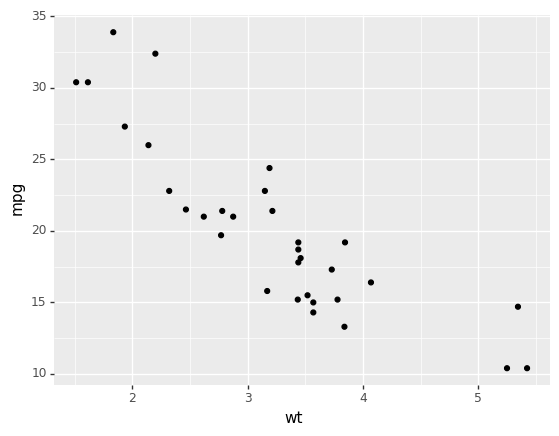

<ggplot: (-9223372036574314345)>

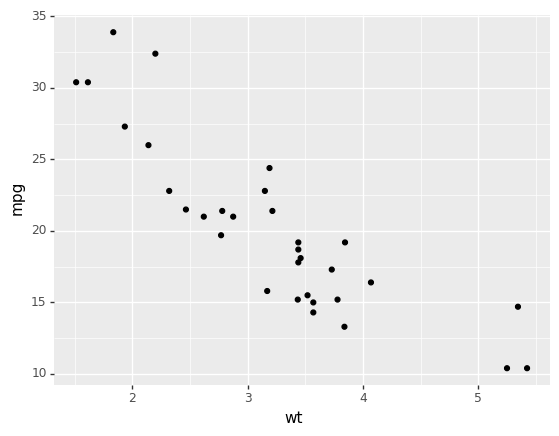

<ggplot: (7014223119)>

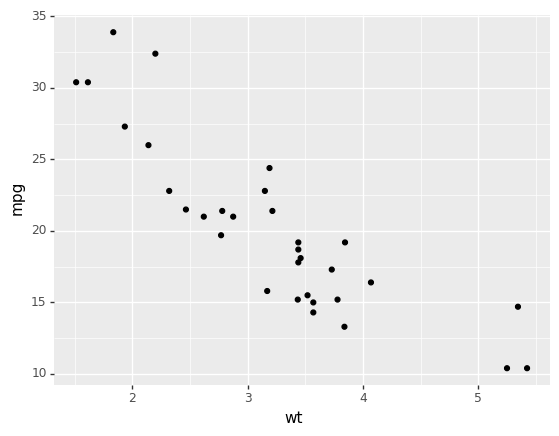

<ggplot: (7014581603)>

In [12]:
# Idiomatic single-liner  
display(ggplot(mtcars, aes('wt', 'mpg')) + geom_point())

# The first step specifies data and quantities to be visualised
p = ggplot(mtcars, aes('wt', 'mpg'))
p = p + geom_point()
display(p)

# The first step specifies only the data 
p = ggplot(data=mtcars)
p = p + geom_point(mapping=aes('wt', 'mpg'))
display(p)

## II. An introduction to basic concepts 

Lets draw performance results for several machine-learning experiments:
* We need to draw scatter plot and line plot.
* We need to colour lines and points according to an experiment. 

### First visualisation just shows the shape of the data

* To be safe we convert experiment type to a categorical value.
* We load the data and spacify two graphs. **They will be put on the same graph.**
* A single ggplot object always describes a single graph or other visualisation element.

,experiment,size,training_accuracy,test_accuracy
0,1,10.6,0.993,0.785
1,1,20.6,0.987,0.799
2,1,30.1,0.984,0.808
3,1,40.6,0.980,0.814
4,1,49.6,0.978,0.819


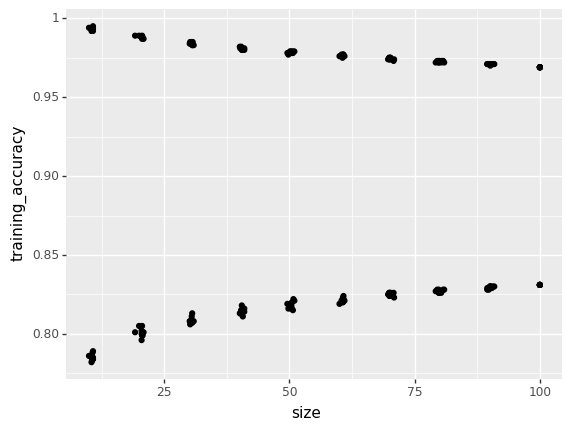

<ggplot: (-9223372029838672594)>

In [43]:
df =(read_csv('performance-results.csv')
     .assign(experiment = lambda df: df['experiment'].astype('category'))
     .assign(size = lambda df: df['size'] * 100))
display(df.head())


p = ggplot(df)
p = p + geom_point(aes(x='size', y='training_accuracy')) 
p = p + geom_point(aes(x='size', y='test_accuracy'))
p

### Second visualisation to capture statistical fluctuations 

* Statistical fluctuations can be visualised with box and violin plots.
* Visualisations are specified as geometric objects `geom_boxplot` and `geom_violin`.
* Each visualisation expects to see a mapping specified as `aes(...)` object.
* If the mapping is not specified, it uses mapping defined in `ggplot` function call.
* The mapping specifies which columns are used to compute the aestetics in the visualisation output.
  * Aestetics `x` and `y` specifie locations in x-axis and y-axis.
  * Aestetics `size`, `color`, `fill`, `linetype` and `shape` the properties of points or lines. 
  * Different visualisations use different aestetics. Look it up from the [plotnine API reference](https://plotnine.readthedocs.io/en/stable/api.html).   
 

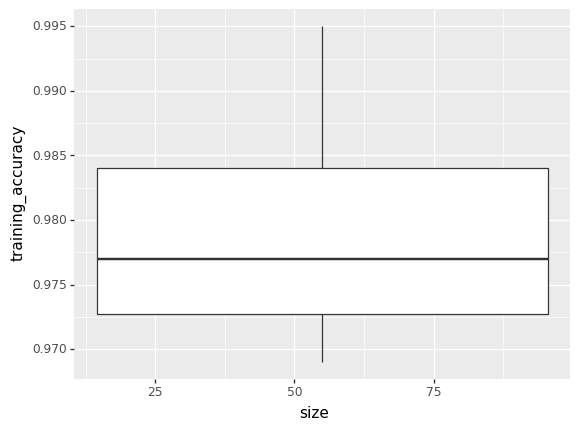

<ggplot: (7015795439)>

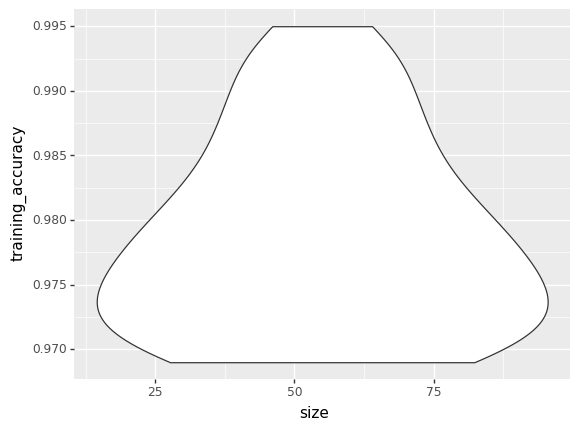

<ggplot: (7015795439)>

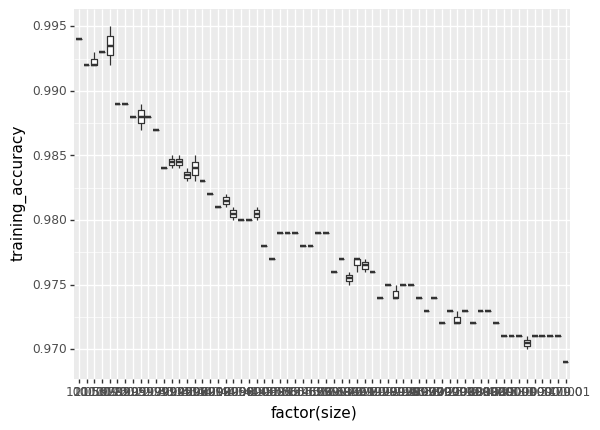

<ggplot: (-9223372029838980401)>

In [52]:
# The first try fails spectacularly. We somehow get only one boxplot
# The x argument must be categorical but it is not in our data.
p = ggplot(df)
p = p + geom_boxplot(aes(x='size', y='training_accuracy')) 
display(p)

# The second try also fails spectacularly. We somehow get only one violin plot
# The x argument must be categorical but it is not in our data.
p = ggplot(df)
p = p + geom_violin(aes(x='size', y='training_accuracy')) 
display(p)


# The third try where we say that x must be converted to cathegorical value works.
# However, the result is bad as there are too many values for the size.  
p = ggplot(df)
p = p + geom_boxplot(aes(x='factor(size)', y='training_accuracy')) 
display(p)

### Third visualisation with precomputed statistics

* Altenatively it is possible to use error bars derived from mean and variance values.
* If there a more data then quantiles are also good way to show variance. 
* As size values are fluctuating around multiples of then we must discretise then in order to make right groups.
* This allows us to compute aggregates for individual groups.
* Constant aestetic values must be specified outside `aes(...)` block.
* No legends are drawn for such constant aesteric values.

In [141]:
sdf = (df
       .assign(group = lambda df: pd.cut(df['size'], bins = [10*i+5 for i in range(11)]))
       .groupby('group')
       .aggregate(size_mean=('size', np.mean), 
                  size_std=('size', np.std), 
                  training_mean=('training_accuracy', np.mean), 
                  training_std=('training_accuracy', np.std),
                  test_mean=('test_accuracy', np.mean),
                  test_std=('test_accuracy', np.std),
                 ))
display(sdf)

,size_mean,size_std,training_mean,training_std,test_mean,test_std
group,,,,,,
"(5, 15]",10.62,0.244040,0.9930,0.001054,0.7850,0.002160
"(15, 25]",20.41,0.481779,0.9881,0.000738,0.8008,0.002741
"(25, 35]",30.50,0.258199,0.9840,0.000816,0.8085,0.002014
"(35, 45]",40.54,0.298887,0.9808,0.000789,0.8142,0.001932
"(45, 55]",50.37,0.437290,0.9784,0.000699,0.8181,0.002378
"(55, 65]",60.63,0.271006,0.9763,0.000675,0.8213,0.001494
"(65, 75]",70.19,0.384274,0.9743,0.000675,0.8250,0.001054
"(75, 85]",80.03,0.533437,0.9725,0.000527,0.8271,0.000876
"(85, 95]",90.13,0.464399,0.9709,0.000316,0.8294,0.000843


Lets draw first averaged lines without error bars.

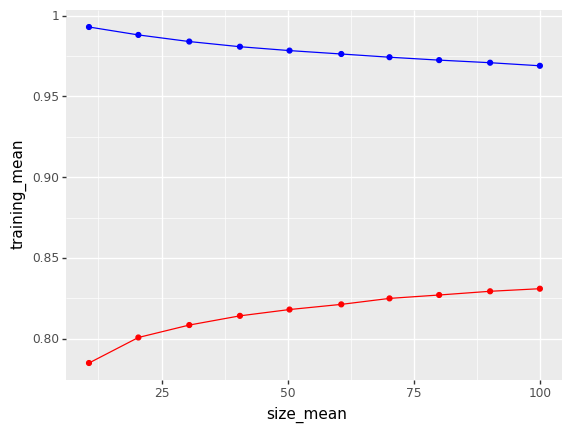

<ggplot: (7019664574)>

In [142]:
p = ggplot(sdf) 
p = p + geom_point(aes(x='size_mean', y='training_mean'), color='blue')
p = p + geom_line(aes(x='size_mean', y='training_mean'), color='blue')
p = p + geom_point(aes(x='size_mean', y='test_mean'), color='red')
p = p + geom_line(aes(x='size_mean', y='test_mean'), color='red')
p

To draw error bars we need to compute more values. As the bars are very tight we draw them two standard deviations appart.

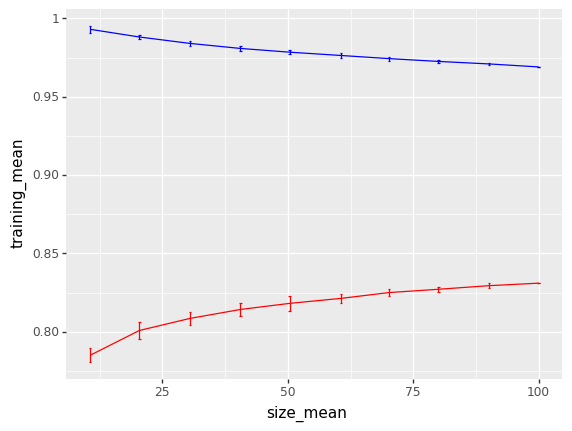

<ggplot: (-9223372029834999727)>

In [143]:
sdf=sdf.assign(
    training_ue = lambda df: df['training_mean'] + 2 * df['training_std'],
    training_le = lambda df: df['training_mean'] - 2 * df['training_std'],
    test_ue = lambda df: df['test_mean'] + 2 * df['test_std'],
    test_le = lambda df: df['test_mean'] - 2 * df['test_std'])

# Note that order of terms is important, as it determines when something is drawn
p = ggplot(sdf) 
p = p + geom_errorbar(aes(x = 'size_mean', ymin = 'training_le', ymax = 'training_ue'), color='blue')
p = p + geom_line(aes(x='size_mean', y='training_mean'), color='blue')
p = p + geom_errorbar(aes(x = 'size_mean', ymin = 'test_le', ymax = 'test_ue'), color='red')
p = p + geom_line(aes(x='size_mean', y='test_mean'), color='red')
p

## III. Grouping and lengends

The previous visualisation was without legends and we had to do a lot of manual work to specify what we wanted to plot. There is an alternative way but we need to reshape the data aka tidy data.
* Observation consists of size, experiment, dataset type and performance. 
* With this structure we can do necessary data aggregation more naturally.
* We need to group data to be visualised into two groups: training and test.
* This is achieved by specifying aestetic value inside `aes(...)` block.

In [147]:
tmp =(df
      .melt(id_vars=['experiment', 'size'], var_name='data_type', value_name='accuracy')
      .assign(data_type=lambda df: df['data_type'].astype('category')
              .cat.rename_categories({'training_accuracy':'Training', 
                                      'test_accuracy':'Test' }))
      .assign(group = lambda df: pd.cut(df['size'], bins = [10*i+5 for i in range(11)]))
     )

display(tmp.head())

sdf = (tmp
       .groupby(['data_type', 'group'])
       .aggregate(size_mean=('size', np.mean), 
                  size_std=('size', np.std), 
                  accuracy_mean=('accuracy', np.mean), 
                  accuracy_std=('accuracy', np.std))
       .reset_index()
       .assign(accuracy_ue = lambda df: df['accuracy_mean'] + 2 * df['accuracy_std'],
               accuracy_le = lambda df: df['accuracy_mean'] - 2 * df['accuracy_std']))
display(sdf.head())

,experiment,size,data_type,accuracy,group
0,1,10.6,Training,0.993,"(5, 15]"
1,1,20.6,Training,0.987,"(15, 25]"
2,1,30.1,Training,0.984,"(25, 35]"
3,1,40.6,Training,0.980,"(35, 45]"
4,1,49.6,Training,0.978,"(45, 55]"


,data_type,group,size_mean,size_std,accuracy_mean,accuracy_std,accuracy_ue,accuracy_le
0,Test,"(5, 15]",10.62,0.244040,0.7850,0.002160,0.789320,0.780680
1,Test,"(15, 25]",20.41,0.481779,0.8008,0.002741,0.806281,0.795319
2,Test,"(25, 35]",30.50,0.258199,0.8085,0.002014,0.812528,0.804472
3,Test,"(35, 45]",40.54,0.298887,0.8142,0.001932,0.818064,0.810336
4,Test,"(45, 55]",50.37,0.437290,0.8181,0.002378,0.822856,0.813344


* Lets reconstuct the last graph wihout colors using only `group` attribute in the `aes(...)` block.
* Data is split into two groups and graphs are drawn but no legends are created.

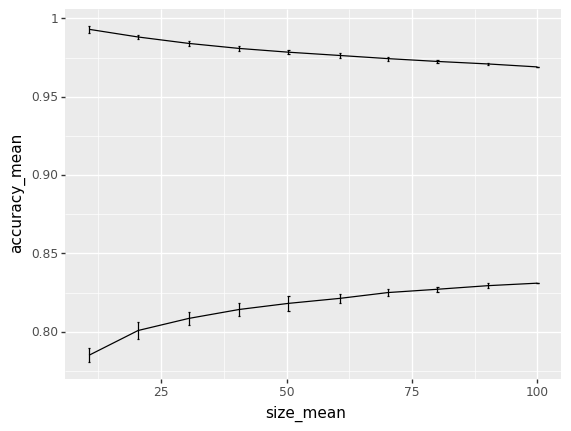

<ggplot: (-9223372029834301766)>

In [156]:
p = ggplot(sdf) 
p = p + geom_errorbar(aes(x = 'size_mean', ymin = 'accuracy_ue', ymax = 'accuracy_le', group='data_type'))
p = p + geom_line(aes(x='size_mean', y='accuracy_mean', group='data_type'))
p

* Lets reconstuct the last graph wihout colors using 'color' and `linestyle` attributes in the `aes(...)` block.
* Data is split into two groups and graphs are drawn and appropriate legends are created.

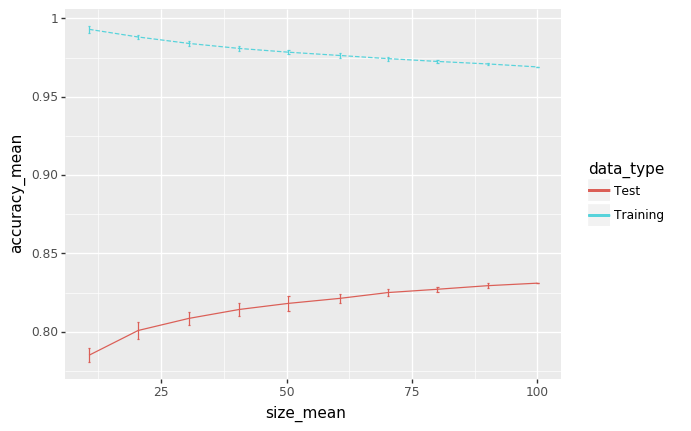

<ggplot: (-9223372029834434472)>

In [157]:
p = ggplot(sdf) 
p = p + geom_errorbar(aes(x = 'size_mean', ymin = 'accuracy_ue', ymax = 'accuracy_le', color='data_type'))
p = p + geom_line(aes(x='size_mean', y='accuracy_mean', color='data_type', linetype='data_type'))
p

## IV. Finetuning visualisation details

* TBA

## III. How to use seaborn 

This is just for comparison.

`cat_dict.values()`

https://medium.com/@gscheithauer/data-visualization-in-python-like-in-rs-ggplot2-bc62f8debbf5  
https://github.com/has2k1/plotnine  
https://plotnine.readthedocs.io/en/stable/

**Seaborn**: make sure that data is float otherwise you get random errors.

https://wckdouglas.github.io/2016/12/seaborn_annoying_title  
https://stackoverflow.com/questions/32899463/how-can-i-overlay-two-graphs-in-seaborn  
https://stackoverflow.com/questions/44261803/change-line-style-in-seaborn-facet-grid  
https://matplotlib.org/gallery/lines_bars_and_markers/line_styles_reference.html

### Displaying results

Lets draw faceted plots for showing large- and small-scale changes.

Note that `seaborn.FacetGrid` provides three channels for spliting data:
* `col` – into which column the data goes
* `ŗow` – into which row the data goes
* `hue` – how the data is colored in the graph

We want to split data according to four categories:
* dataset dimensionality
* the type of labelling function
* machine learning method
* behaviour on test and train data

We must cheat and combine the last two categories into a single `hue` channel.

To get desired visual separation we must manually control aesthetics of four hue groups.
It is a bit hacky but we get the things done.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

%matplotlib inline

# Manual control of hue groups
hue_order = ['LR-test', 'LR-train', 'MV-test', 'MV-train']
hue_kws = {'color':      ['blue', 'orange', 'blue', 'orange'], 
           'marker':     ['X', 'X', '.', '.'],
           'linestyle':  ['-', '-', '-.', '-.']
          }

In [ ]:
df = (error.loc[error['size'].isin([10, 1000, 2000, 3000, 4000, 5000]),:]
      .assign(hue = lambda df: combine_columns(df, ['method', 'type'], "-")))

fg = sns.FacetGrid(df, col="dim", row="fit", hue = "hue", 
                   hue_order=hue_order, hue_kws=hue_kws,
                   margin_titles = True)
fg.map(plt.plot, "size", "accuracy")
fg.map(plt.scatter, "size", "accuracy")
fg.add_legend(title = "Accuracy")

In [ ]:
df = (error.loc[error['size'] <= 1000,:]
      .assign(hue = lambda df: combine_columns(df, ['method', 'type'], "-")))

fg = sns.FacetGrid(df, col="dim", row="fit", hue = "hue", 
                   hue_order=hue_order, hue_kws=hue_kws,
                   margin_titles = True)
fg.map(plt.plot, "size", "accuracy", marker ='s')
fg.map(plt.scatter, "size", "accuracy")
fg.add_legend(title = "Accuracy")

## Leftovers

**Seaborn**: make sure that data is `float`, otherwise you get random errors.

https://wckdouglas.github.io/2016/12/seaborn_annoying_title  
https://stackoverflow.com/questions/32899463/how-can-i-overlay-two-graphs-in-seaborn  
https://stackoverflow.com/questions/44261803/change-line-style-in-seaborn-facet-grid